# 1. Entendimiento y preparación de los datos

El dataset suministrado está conformado por 43.013 registros y 46 variables que describen en detalle las características físicas, geográficas y de entorno de diferentes viviendas tipo apartamento. Incluye información estructural como el número de habitaciones, baños, parqueaderos, área total y estrato socioeconómico, así como atributos del entorno como la proximidad a estaciones de transporte masivo, parques y zonas recreativas.
Además, incorpora variables complementarias relacionadas con las amenidades del inmueble (presencia de ascensor, piscina, gimnasio, vigilancia, chimenea, terraza, jacuzzi, entre otras) y variables geoespaciales como latitud, longitud y distancia a puntos de interés, lo que permite realizar análisis espaciales.
El conjunto también contiene variables descriptivas y administrativas, incluyendo la cuota de administración, tipo de propiedad, antigüedad, sector, barrio, y compañía inmobiliaria, además del precio de venta, que corresponde a la variable objetivo del estudio.

### Carga y limpieza de Datos

In [101]:
# Importación de librerías
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy.stats as stats
from scipy.stats import chi2_contingency
pd.set_option('display.max_columns', None)

def convertir_float(cast_columns_float,df):
    for i in cast_columns_float:
        df[i]=(
        pd.to_numeric(df[i], errors="coerce")
          .round()
          .astype(float)
        )    

In [102]:
# carga fuente insumo
apartamentos_df = pd.read_csv("data/apartamentos.csv")

In [103]:
# Dimensiones dataset
apartamentos_df.shape

(43013, 46)

In [104]:
# Lista de columnas a castear según lo indica el Diccionario de Datos
cast_columns_float = ["codigo"]
#creacion de un nuevo dataframe que será transformado y limipiado
apartamentos_df_clean=apartamentos_df
# Casteo columnas a string segun el diccionario de datos 
convertir_float(cast_columns_float,apartamentos_df_clean)
#se eliminan duplicados
apartamentos_df_clean = apartamentos_df_clean.drop_duplicates()
# Se aplica el filtro de tipo de propiedad igual a Apartamento debido a que el modelo a desarrollar esta orientado a esta clase de vivienda
apartamentos_df_clean=apartamentos_df_clean[(apartamentos_df_clean['tipo_propiedad']=='APARTAMENTO') & (apartamentos_df_clean['tipo_operacion']=='VENTA')]
# se selecciona que si el parqueadero es menor a cero, lo limita a cero y si es mayor a 10 lo limita a 10.
apartamentos_df_clean["parqueaderos"] = apartamentos_df_clean["parqueaderos"].clip(upper=8)
apartamentos_df_clean["parqueaderos"] = apartamentos_df_clean["parqueaderos"].clip(lower=0)


### Indicadores importantes

#### Indicador distribucion por localidad

Indicador de la cantidad de apartamentos y precio promedio por localidad. Este indicador muestra las localidades con mas oferta inmobiliaria y un costo promedio de venta aproximado.

In [9]:
pd.set_option('display.float_format', '{:.2f}'.format)

tabla = (
    apartamentos_df_clean.groupby('localidad', as_index=False)
      .agg(
          num_apartamentos=('localidad', 'count'),
          precio_promedio=('precio_venta', 'mean'),
          area_promedio=('area', 'mean'),
      )
)

tabla['porcentaje'] = (tabla['num_apartamentos'] / tabla['num_apartamentos'].sum() * 100).round(1)
tabla['precio_m2'] = (tabla['precio_promedio'] / tabla['area_promedio'].sum() * 100).round(1)
tabla.sort_values(by='num_apartamentos',ascending=False).head()


,localidad,num_apartamentos,precio_promedio,area_promedio,porcentaje,precio_m2
17,USAQUEN,9868,1911840819.85,150.47,36.30,119997675.90
4,CHAPINERO,7266,4594872756.29,193.09,26.70,288399560.30
14,SUBA,5074,1584947111.07,121.37,18.70,99480023.50
7,FONTIBON,1055,2499934755.92,89.73,3.90,156909695.40
8,KENNEDY,848,598721943.30,57.23,3.10,37579091.80


Existe una mayor oferta inmobiliaria en la localidad de Usaquen con cerca del 34% del total. Las localidades de Fontibon y KEnnedy suman menos de un 7% de participacion total. Por otro lado, el mayor precio promedio de venta por apartamento corresponde a la localidad de chapinero con cerca de 4500 millones en promedio. La localidad que tiene el precio promedio por metro cuadrado mas caro es Chapinero con cerca de 247 millones por metro cuadrado, le sigue Fontibon y Usaquen. La localidad que ofrece el metro cuadrado en promedio mas economico es Kennedy.

#### Indicadores de accesibilidad y entorno

In [10]:
apartamentos_df_clean["is_cerca_estacion_tm"].value_counts(normalize=True,dropna=False)

is_cerca_estacion_tm
0   0.79
1   0.21
Name: proportion, dtype: float64

In [11]:
apartamentos_df_clean["is_cerca_parque"].value_counts(normalize=True,dropna=False)

is_cerca_parque
0   0.74
1   0.26
Name: proportion, dtype: float64

El 21 % de los apartamentos estan cerca a transmilenio, mientras que el 27% esta cerca a parques. Como son porcentajes pequeños para cada categoría, puede que sean mas valoradas los inmuebles que estan cerca a transporte publico y a parques, mas adelante comporbaremos si tienen estas dos variables significancia a la hora de predecir el valor de una vivienda.

### Features seleccionadas



####  **Variable objetivo**

**precio_venta**: Es la variable dependiente (target) del modelo. Será el objetivo de predicción del modelo de regresión, expresado en pesos

---
####  **Variables predictoras (features)**

##### ** Atributos estructurales**

Estas variables describen las características físicas del apartamento.

| Variable       | Tipo              | Justificación                                                                                      |
| :------------- | :---------------- | :------------------------------------------------------------------------------------------------- |
| `area`         | Numérica continua | Una de las variables más influyentes. El precio suele crecer proporcionalmente con el tamaño (m²). |
| `habitaciones` | Numérica discreta | Indicador del tamaño funcional del inmueble.                   |
| `banos`        | Numérica discreta | Mejora la comodidad y aumenta el valor percibido.                                                  |
| `parqueaderos` | Numérica discreta | Un factor importante de valorización en ciudades con alta densidad y escasez de parqueo.           |
| `administracion` | Numérica continua | Cuota que debe pagar por propiedad del inmueble           |


##### ** Atributos de localización**

Aportan información espacial

| Variable    | Tipo       | Justificación                                                                                         |
| :---------- | :--------- | :---------------------------------------------------------------------------------------------------- |
| `latitud` | Numerica discreta | localización es uno de los principales determinantes del valor inmobiliario  |
| `longitud` | Numerica discreta | localización es uno de los principales determinantes del valor inmobiliario  |


##### ** Atributos socioeconómicos y de estado**

Aporta información de estrato y estado del inmueble

| Variable  | Tipo              | Justificación                                                                                                 |
| :-------- | :---------------- | :------------------------------------------------------------------------------------------------------------ |
| `estrato` | Numérica discreta | Refleja poder adquisitivo, infraestructura y nivel socioeconómico del sector.  |
| `estado`  | Categórica        | Indica si el inmueble es nuevo, usado o remodelado. Relevante en la percepción de valor.                      |


##### ** Atributos de entorno**

Variables binarias que reflejan accesibilidad y calidad de vida

| Variable               | Tipo          | Justificación                                                                                                                                |
| :--------------------- | :------------ | :------------------------------------------------------------------------------------------------------------------------------------------- |
| `is_cerca_estacion_tm` | Binaria (0/1) | La cercanía al transporte público puede aumentar el valor por accesibilidad o disminuirlo por ruido; útil para explicar variaciones locales. |
| `is_cerca_parque`      | Binaria (0/1) | Refleja proximidad a zonas verdes, lo que mejora la calidad de vida y suele elevar el valor percibido.                                       |

### Aumento de Data

La función augment_dataset() duplica el tamaño del conjunto de datos original (n_samples=0.5, equivalente al 50% adicional) mediante la creación de observaciones sintéticas. A las variables numéricas continuas (por ejemplo, area, administracion, latitud, longitud, precio_venta) se les añade un ruido gaussiano controlado con una desviación estándar equivalente al 2% del valor original (noise_factor=0.02), lo que genera pequeñas perturbaciones que simulan variaciones realistas sin alterar la distribución general. Las variables discretas o enteras (habitaciones, banos, parqueaderos, estrato) también reciben un ruido leve, pero luego se redondean y limitan para mantener su integridad numérica. as variables binarias o booleanas (is_cerca_estacion_tm, is_cerca_parque, estado_USADO) se mantienen sin modificación, ya que representan condiciones lógicas (0/1) que no deben ser perturbadas

In [14]:
def augment_dataset(df, noise_factor=0.02, n_samples=0.5, random_state=42):
    # Copiamos un subconjunto de datos
    df_aug = df.sample(frac=n_samples, replace=True, random_state=random_state).copy()

    # Variables numéricas continuas
    cont_vars = ['area', 'administracion', 'latitud', 'longitud', 'precio_venta']
    # Variables discretas (enteras)
    disc_vars = ['habitaciones', 'banos', 'parqueaderos', 'estrato']
    # Variables booleanas (sin modificar)
    bool_vars = ['is_cerca_estacion_tm', 'is_cerca_parque', 'estado_USADO']

    # Agregar ruido a las continuas
    for col in cont_vars:
        df_aug[col] = df_aug[col] + np.random.normal(0, noise_factor * df[col].std(), df_aug.shape[0])

    # Agregar ruido controlado a las discretas (y redondear)
    for col in disc_vars:
        df_aug[col] = np.round(df_aug[col] + np.random.normal(0, noise_factor * df[col].std(), df_aug.shape[0]))
        # Aseguramos que no haya valores negativos
        df_aug[col] = df_aug[col].clip(lower=0)

    # Mantenemos las booleanas igual
    df_aug[bool_vars] = df_aug[bool_vars].astype(int)

    # Combinamos dataset original + aumentado
    df_final = pd.concat([df, df_aug], ignore_index=True)
    
    return df_final
apartamentos_df_aug = augment_dataset(apartamentos_df_clean, noise_factor=0.03, n_samples=0.5)


C:\Users\Diego\AppData\Local\Temp\ipykernel_25180\3016353934.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_comparado, x='tipo', y='precio_venta', palette='Set2')


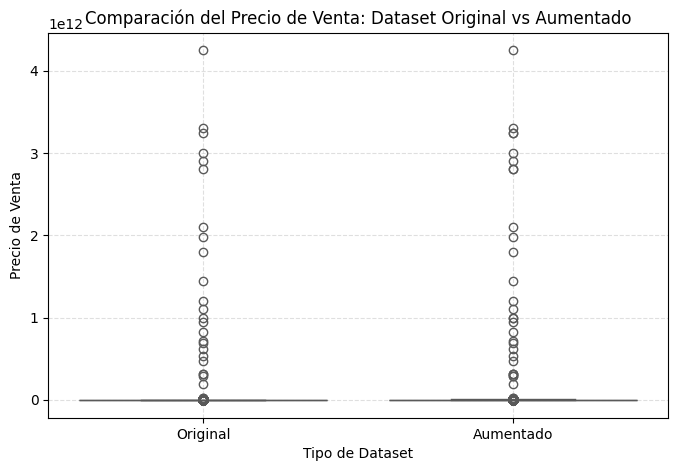

In [15]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Primero combinamos ambos datasets y agregamos una etiqueta
df_original = apartamentos_df_clean.copy()
df_original['tipo'] = 'Original'

df_aug = apartamentos_df_aug.copy()
df_aug['tipo'] = 'Aumentado'

# Unimos ambos
df_comparado = pd.concat([df_original, df_aug], ignore_index=True)

# Creamos el boxplot
plt.figure(figsize=(8,5))
sns.boxplot(data=df_comparado, x='tipo', y='precio_venta', palette='Set2')
plt.title('Comparación del Precio de Venta: Dataset Original vs Aumentado')
plt.xlabel('Tipo de Dataset')
plt.ylabel('Precio de Venta')
plt.grid(True, linestyle='--', alpha=0.4)
plt.show()


# 2. Entendimiento del modelo de machine learning

Se realiza una preparacion de la variable "estado" con el fin de volverla categorica.

In [105]:
apartamentos_df_clean.sample(5)

,_id,codigo,tipo_propiedad,tipo_operacion,precio_venta,area,habitaciones,banos,administracion,parqueaderos,sector,estrato,antiguedad,latitud,longitud,direccion,descripcion,website,last_view,datetime,url,timeline,estado,compañia,precio_arriendo,jacuzzi,piso,closets,chimenea,permite_mascotas,gimnasio,ascensor,conjunto_cerrado,piscina,salon_comunal,terraza,vigilancia,coords_modified,localidad,barrio,estacion_tm_cercana,distancia_estacion_tm_m,is_cerca_estacion_tm,parque_cercano,distancia_parque_m,is_cerca_parque
10297,66d86cb5ceda690e8550af99,NaN,APARTAMENTO,VENTA,6.400000e+09,363.0,4.0,5.0,2000000.0,4.0,CHICO,6.0,ENTRE 0 Y 5 ANOS,4.671177,-74.043390,NaN,lujoso apartamento ubicado en el exclusivo sec...,metrocuadrado.com,2024-08-18 17:09:47.088,2024-07-04 10:15:57.222,NaN,[],USADO,LUZ ELENA BALAUSTRE,NaN,1.0,NaN,NaN,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,False,CHAPINERO,CHICO ORIENTAL,Calle 85,1805.36,0,PARQUE VECINAL URBANIZACIÓN LA CABRERA,779.61,0
22191,66d86d36ceda690e8550de0f,NaN,APARTAMENTO,VENTA,8.200000e+08,89.0,2.0,2.0,1086000.0,1.0,CHICO,6.0,MAS DE 20 ANOS,4.674904,-74.044266,NaN,"lindo apartamento, completamente remodelado, d...",metrocuadrado.com,2024-08-13 20:55:17.275,2024-07-07 18:46:40.318,NaN,[],USADO,MAVICLA FINCA RAIZ,NaN,0.0,NaN,NaN,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,False,CHAPINERO,S.C. CHICO NORTE,Virrey,1638.76,0,PARQUE VECINAL URBANIZACIÓN LA CABRERA,860.18,0
39648,66d86e71ceda690e85512240,NaN,APARTAMENTO,VENTA,1.705000e+08,57.0,3.0,1.0,150000.0,1.0,KENNEDY,2.0,REMODELADO,4.634508,-74.176650,NaN,"apartamento en venta de 57m2, con vista interi...",metrocuadrado.com,2024-08-13 17:32:19.535,2024-08-13 17:32:19.535,NaN,NaN,USADO,VIVIENDAS-JR,NaN,0.0,NaN,NaN,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,False,KENNEDY,LAS MARGARITAS OCCIDENTAL,Portal Américas,695.29,0,PARQUE METROPOLITANO EL PORVENIR (GIBRALTAR),467.51,1
41243,66d86e95ceda690e8551287b,4291550.0,APARTAMENTO,VENTA,1.346400e+08,45.0,2.0,1.0,62700.0,0.0,BOSA CENTRAL,1.0,ENTRE 5 Y 10 ANOS,4.613604,-74.201355,CALLE 77SUR # 81 - 80,"apartamento en venta de 45m2, con vista interi...",habi.co,2024-08-18 14:49:07.834,2024-08-18 14:49:07.834,https://habi.co/page-data/venta-apartamentos/1...,NaN,NaN,NaN,NaN,0.0,NaN,NaN,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,False,BOSA,S.C. LOS LAURELES,León XIII,2550.50,0,PARQUE ZONAL PARQUE DEL RIO (SAN JOSE DE MARYL...,205.44,1
21955,66d86d33ceda690e8550dd23,NaN,APARTAMENTO,VENTA,3.190000e+08,60.0,2.0,2.0,280000.0,1.0,COLINA Y ALREDEDORES,3.0,ENTRE 5 Y 10 ANOS,4.720125,-74.055214,NaN,te presentamos este acogedor apartamento de do...,metrocuadrado.com,2024-08-13 14:58:57.124,2024-07-07 17:52:01.801,NaN,[],USADO,Y&C BIENES RAICES,NaN,0.0,NaN,NaN,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,False,SUBA,PRADO VERANIEGO,Alcalá – Colegio S. Tomás Dominicos,432.21,1,PARQUE VECINAL PRADO PINZÓN,693.53,0


In [97]:
import pandas as pd
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import xgboost as xgb
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor

#!pip install scikit-learn
#!pip install xgboost
pd.set_option('display.max_columns', None)

In [106]:
Q1 = apartamentos_df_clean['precio_venta'].quantile(0.25)
Q3 = apartamentos_df_clean['precio_venta'].quantile(0.75)
IQR = Q3 - Q1

# Definir límites
limite_inferior = Q1 - 1.5 * IQR
limite_superior = Q3 + 1.5 * IQR

# Filtrar outliers
apartamentos_df_clean = apartamentos_df_clean[
    (apartamentos_df_clean['precio_venta'] >= limite_inferior) &
    (apartamentos_df_clean['precio_venta'] <= limite_superior)
]

# Filtrar outliers
apartamentos_df_clean = apartamentos_df_clean[
    (apartamentos_df_clean['precio_venta'] >= 10000000) 
]

In [107]:
import pandas as pd
import numpy as np

# Definir el tamaño del intervalo
bin_size = 10_000_000  # 10 millones

# Crear los límites (desde 0 hasta el máximo redondeado al siguiente múltiplo de 10 millones)
max_value = apartamentos_df_clean['precio_venta'].max()
bins = np.arange(0, max_value + bin_size, bin_size)

# Crear las etiquetas (ej. 0-10M, 10M-20M, ...)
labels = [f"{int(b/1e6)}M - {int((b+bin_size)/1e6)}M" for b in bins[:-1]]

# Crear la nueva columna categórica
apartamentos_df_clean['precio_venta_categoria'] = pd.cut(
    apartamentos_df_clean['precio_venta'],
    bins=bins,
    labels=labels,
    include_lowest=True
)
apartamentos_df_clean[['precio_venta', 'precio_venta_categoria']].head(10)
apartamentos_df_clean['precio_venta_categoria'].value_counts().sort_index()


precio_venta_categoria
0M - 10M          0
10M - 20M         1
20M - 30M         0
30M - 40M         1
40M - 50M         0
                 ..
2590M - 2600M    88
2600M - 2610M     0
2610M - 2620M     2
2620M - 2630M     0
2630M - 2640M     2
Name: count, Length: 264, dtype: int64

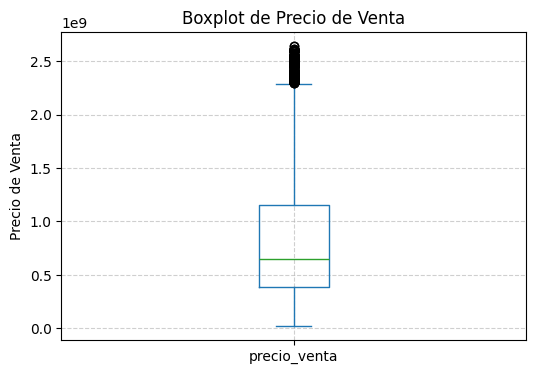

In [84]:
apartamentos_df_clean['precio_venta'].plot(kind='box', figsize=(6, 4))
plt.title('Boxplot de Precio de Venta')
plt.ylabel('Precio de Venta')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

In [ ]:
apartamentos_df_clean = apartamentos_df_clean[[
    "area", "habitaciones", "banos", "parqueaderos", "administracion", "vigilancia","conjunto_cerrado",
    "latitud", "longitud", "estrato",
    "is_cerca_estacion_tm", "is_cerca_parque", "precio_venta",
    "closets" ,"chimenea" ,"gimnasio" ,"ascensor" ,"salon_comunal"
]]

# Convertir 'estado' a 1 (USADO) y 0 (NUEVO)
apartamentos_df_clean['vigilancia'] = apartamentos_df_clean['vigilancia'].fillna(0).astype(int)
apartamentos_df_clean['conjunto_cerrado'] = apartamentos_df_clean['conjunto_cerrado'].fillna(0).astype(int)
apartamentos_df_clean['chimenea'] = apartamentos_df_clean['chimenea'].fillna(0).astype(int)
apartamentos_df_clean['closets'] = apartamentos_df_clean['closets'].fillna(0).astype(int)
apartamentos_df_clean['gimnasio'] = apartamentos_df_clean['gimnasio'].fillna(0).astype(int)
apartamentos_df_clean['ascensor'] = apartamentos_df_clean['ascensor'].fillna(0).astype(int)
apartamentos_df_clean['salon_comunal'] = apartamentos_df_clean['salon_comunal'].fillna(0).astype(int)


# no se tiene encuenta la variable 
# terraza,jacuzzi,piscina y precio arriendo 
# estado_USADO
# porque tiene una alta asimetria positiva y no aportan al modelo
# apartamentos_df_clean['terraza'] = apartamentos_df_clean['terraza'].fillna(0).astype(int)


In [113]:
col_sel=[
    "area", "habitaciones", "banos", "parqueaderos", "administracion", "vigilancia","conjunto_cerrado",
    "latitud", "longitud", "estrato",
    "is_cerca_estacion_tm", "is_cerca_parque", "precio_venta",
    "closets" ,"chimenea" ,"gimnasio" ,"ascensor" ,"salon_comunal","precio_arriendo"
]
apartamentos_df_clean.loc[:,col_sel].skew()

area                    -0.140754
habitaciones            -0.475213
banos                    0.421253
parqueaderos             0.278036
administracion          -0.134229
vigilancia              -0.361949
conjunto_cerrado         0.276491
latitud                 -0.756577
longitud                -1.704280
estrato                 -0.600880
is_cerca_estacion_tm     1.386752
is_cerca_parque          1.120602
precio_venta             1.089499
closets                  0.000000
chimenea                 0.000000
gimnasio                 0.843559
ascensor                -0.613586
salon_comunal            0.000000
precio_arriendo         17.735654
dtype: float64

In [112]:
for columns in ["area","administracion","precio_arriendo"]:
    apartamentos_df_clean[columns]=np.log1p(apartamentos_df_clean[columns])

In [114]:
# Se elimina registros faltantes por seguridad
df = apartamentos_df_clean.dropna()
print(df.shape)

# Variables
X = df.drop(columns=['precio_venta'])
y = df['precio_venta']
# y = np.log1p(df['precio_venta'])
# 60% train, 20% test, 20% validation
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

(22993, 19)


In [115]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [116]:
param_grid_rf = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

rf = RandomForestRegressor(random_state=42)

grid_rf = GridSearchCV(
    estimator=rf,
    param_grid=param_grid_rf,
    cv=3,              # validación cruzada de 3 folds
    scoring='neg_mean_absolute_error',      # métrica de evaluación
    n_jobs=-1,         # usa todos los núcleos disponibles
    verbose=1
)

grid_rf.fit(X_train, y_train)

print("🌲 Mejor configuración Random Forest:")
print(grid_rf.best_params_)
print(f"Mejor MAE (train CV): {grid_rf.best_score_:.3f}")


Fitting 3 folds for each of 24 candidates, totalling 72 fits
🌲 Mejor configuración Random Forest:
{'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Mejor MAE (train CV): -110910110.712


In [117]:
param_grid_xgb = {
    'n_estimators': [100, 200],
    'learning_rate': [0.05, 0.1],
    'max_depth': [3, 5, 7],
    'subsample': [0.8, 1],
    'colsample_bytree': [0.8, 1]
}

xgb = XGBRegressor(random_state=42)

grid_xgb = GridSearchCV(
    estimator=xgb,
    param_grid=param_grid_xgb,
    cv=3,
    scoring='neg_mean_absolute_error',
    n_jobs=-1,
    verbose=1
)

grid_xgb.fit(X_train, y_train)

print("⚡ Mejor configuración XGBoost:")
print(grid_xgb.best_params_)
print(f"Mejor MAE (train CV): {grid_xgb.best_score_:.3f}")


Fitting 3 folds for each of 48 candidates, totalling 144 fits
⚡ Mejor configuración XGBoost:
{'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 200, 'subsample': 1}
Mejor MAE (train CV): -111111997.347


In [118]:
# Modelos optimizados
best_rf = grid_rf.best_estimator_
best_xgb = grid_xgb.best_estimator_

# Predicciones
rf_pred = best_rf.predict(X_test)
xgb_pred = best_xgb.predict(X_test)

# Métricas
def evaluar_modelo(y_true, y_pred, nombre_modelo):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    print(f"\n📊 {nombre_modelo}")
    print(f"RMSE: {rmse:,.0f}")
    print(f"R²: {r2:.3f}")
    print(f"MAE: {mae:.3f}")

evaluar_modelo(y_test, rf_pred, "Random Forest (Optimizado)")
evaluar_modelo(y_test, xgb_pred, "XGBoost (Optimizado)")


📊 Random Forest (Optimizado)
RMSE: 177,598,193
R²: 0.907
MAE: 109250062.611

📊 XGBoost (Optimizado)
RMSE: 177,137,310
R²: 0.908
MAE: 111390749.103


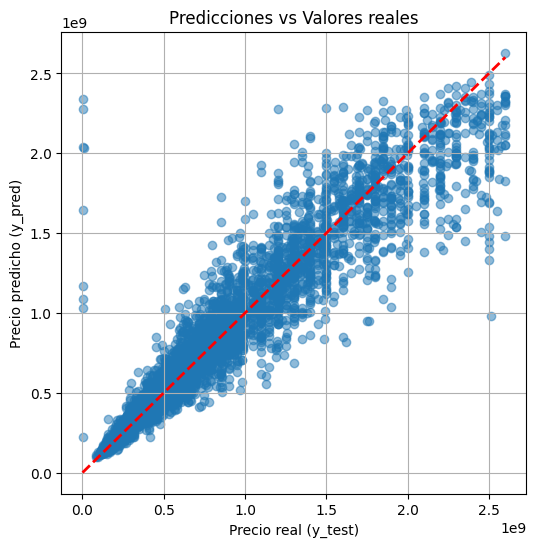

In [66]:
plt.figure(figsize=(6,6))
plt.scatter(y_test, xgb_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)

plt.title('Predicciones vs Valores reales')
plt.xlabel('Precio real (y_test)')
plt.ylabel('Precio predicho (y_pred)')
plt.grid(True)
plt.show()